# Deep Evidential Regression
Deep Evidential Regression (DER) is a technique that trains a single deterministic network to learn four outputs which characterize evidential priors over the original Gaussian likelihood function. We learn the parameters of a joint conjugate prior (Normal-Inverse-Gamma) that hierarchically parameterizes the Gaussian likelihood.

Following - https://arxiv.org/abs/1910.02600

With a modified loss function and calculation of aleatoric and epistemic uncertainty from - https://arxiv.org/abs/2205.10060 

The loss function modification and DER and SDER models are taken from - https://github.com/pasteurlabs/unreasonable_effective_der/tree/main

In [1]:
import torch
import functools
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from scripts import train, models, analysis, io

In [3]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

In [4]:
DEVICE = get_best_device()

In [47]:
DER_TYPE = 'DER'  # 'sDER'
noise = 'medium'
# model_name will be used to save the model by checkpoint
model_name = DER_TYPE + '_noise_' + noise
norm = 'False' # if you normalize, rn the normalized version doesn't work
n_epochs = 100
BATCH_SIZE = 100

In [48]:
if DER_TYPE == 'DER':
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
    DERLayer = models.DERLayer
    loss_der = models.loss_der
if DER_TYPE == 'SDER':
    #The below were the numbers for SDER originally
    #LR = .005    # learning rate
    #COEFF = 2.   # lambda
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
    DERLayer = models.SDERLayer
    loss_der = models.loss_sder

## Load linear data from h5
There are multiple noise options, so define sigma first.

In [49]:
if noise == 'low':
    sigma = 1
if noise == 'medium':
    sigma = 5
if noise == 'high':
    sigma = 10
size_df = 1000

In [50]:
loader = io.DataLoader()

In [51]:
data = loader.load_data_h5('linear_sigma_'+str(sigma)+'_size_'+str(size_df))

In [52]:
len_df = len(data['params'][:,0].numpy())
len_x = len(data['inputs'].numpy())
ms_array = np.repeat(data['params'][:,0].numpy(), len_x)
bs_array = np.repeat(data['params'][:,1].numpy(), len_x)
xs_array = np.tile(data['inputs'].numpy(), len_df)
ys_array = np.reshape(data['output'].numpy(), (len_df * len_x))

print('shapes',
      np.shape(ms_array),
      np.shape(bs_array),
      np.shape(xs_array),
      np.shape(ys_array))

shapes (101000,) (101000,) (101000,) (101000,)


<Figure size 640x480 with 0 Axes>

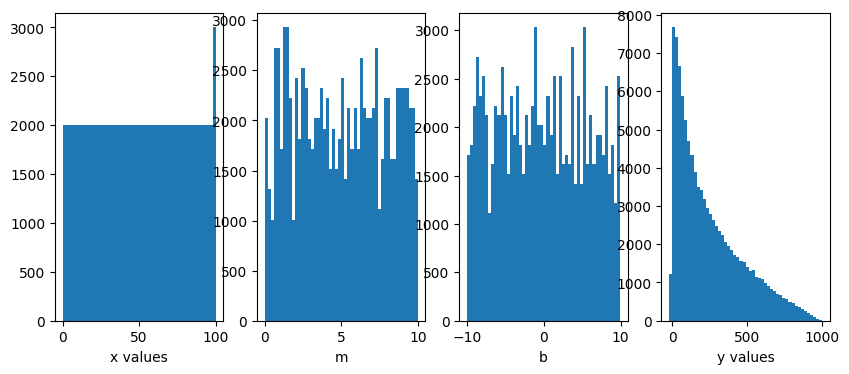

In [53]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [54]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [55]:
if norm == 'True':
    print('normalized version', norm)
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    print('not normalizing')
    model_inputs = inputs
    model_outputs = ys_array

not normalizing


<Figure size 640x480 with 0 Axes>

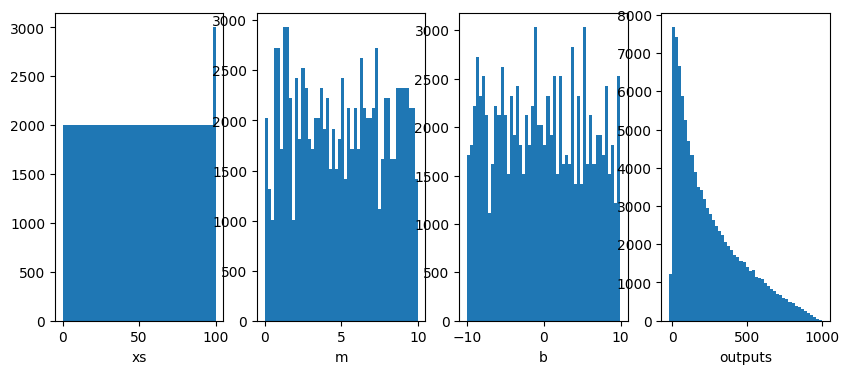

In [56]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

(90900, 3) (90900,)
(3,)


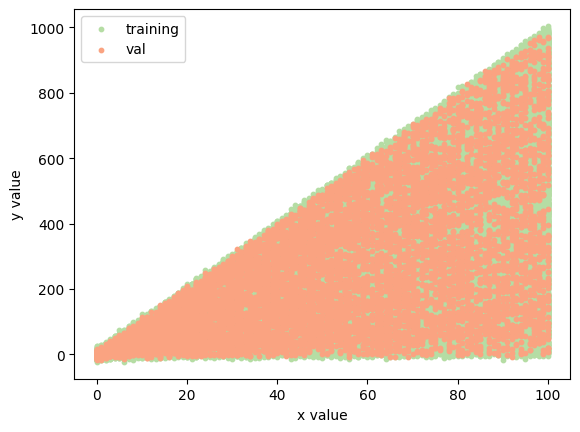

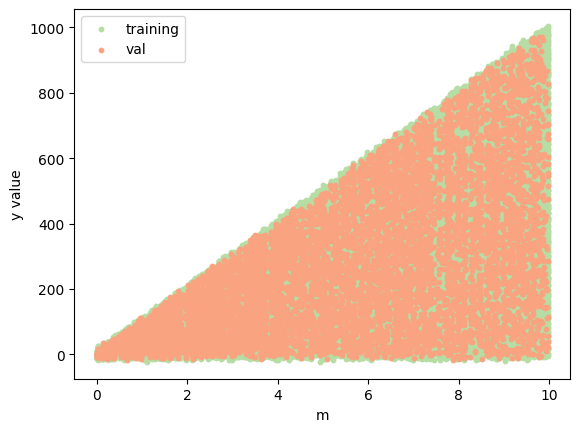

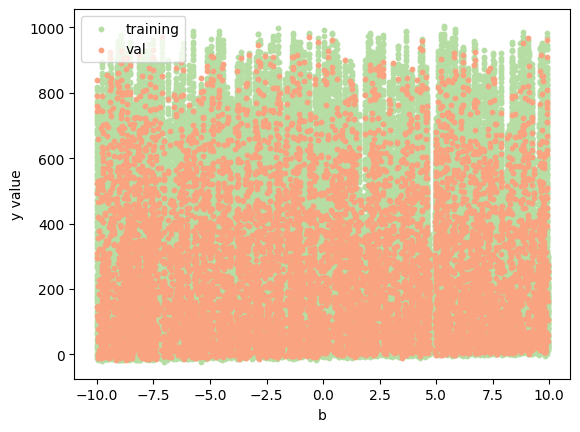

In [57]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [58]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


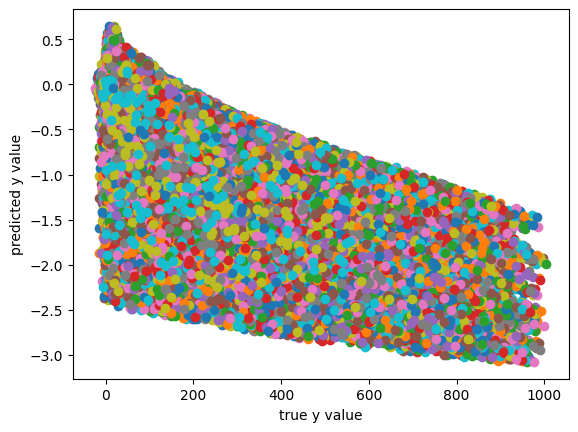

In [59]:
# plot what we're trying to predict
counter = 0
model, loss = models.model_setup_DER(DER_TYPE, DEVICE)
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(DEVICE), y.to(DEVICE))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()

    
    plt.scatter(y, pred[:,0], linestyle='None')
    
    counter += 1
plt.xlabel('true y value')
plt.ylabel('predicted y value')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()

[INFO] training the network...
saving checkpoints?
True
saving here: ../models/
model name: DER_noise_medium
epoch 0 0.0


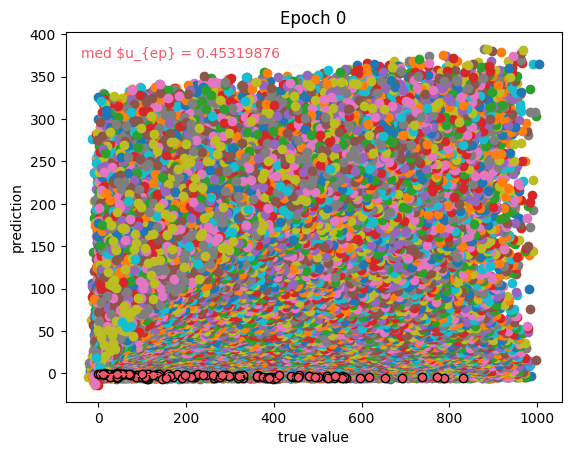

new best loss 7.326869010925293 in epoch 0
epoch 1 0.01
new best loss 5.916833400726318 in epoch 1
epoch 2 0.02
new best loss 5.026534080505371 in epoch 2
epoch 3 0.03
new best loss 4.814828872680664 in epoch 3
epoch 4 0.04
new best loss 4.377506732940674 in epoch 4
epoch 5 0.05


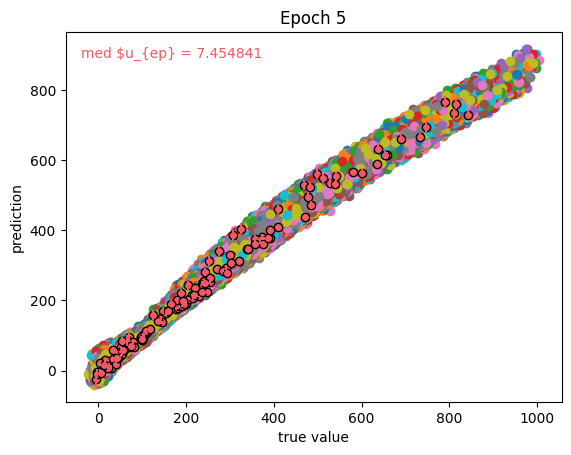

new best loss 4.170192241668701 in epoch 5
epoch 6 0.06
new best loss 3.9185221195220947 in epoch 6
epoch 7 0.07
new best loss 3.786888837814331 in epoch 7
epoch 8 0.08
new best loss 3.6590564250946045 in epoch 8
epoch 9 0.09
new best loss 3.5037615299224854 in epoch 9
epoch 10 0.1


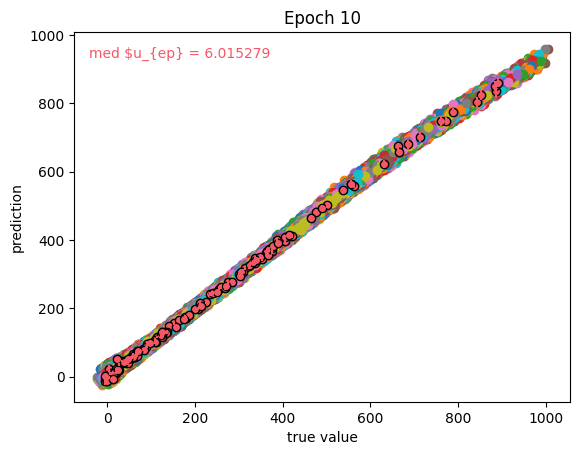

new best loss 3.461801528930664 in epoch 10
epoch 11 0.11
new best loss 3.3846848011016846 in epoch 11
epoch 12 0.12
new best loss 3.3365609645843506 in epoch 12
epoch 13 0.13
new best loss 3.3065755367279053 in epoch 13
epoch 14 0.14
new best loss 3.273587465286255 in epoch 14
epoch 15 0.15


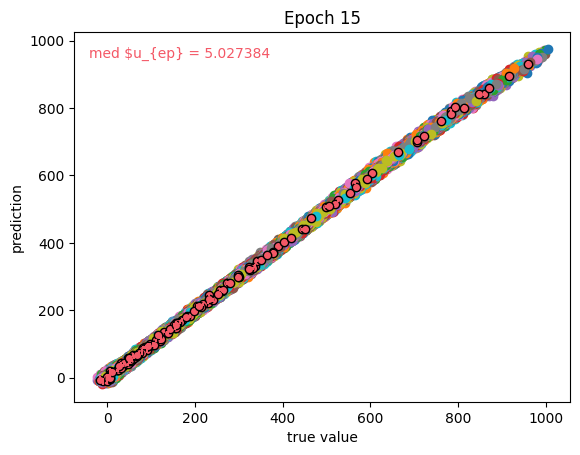

epoch 16 0.16
epoch 17 0.17
epoch 18 0.18
new best loss 3.257263422012329 in epoch 18
epoch 19 0.19
epoch 20 0.2


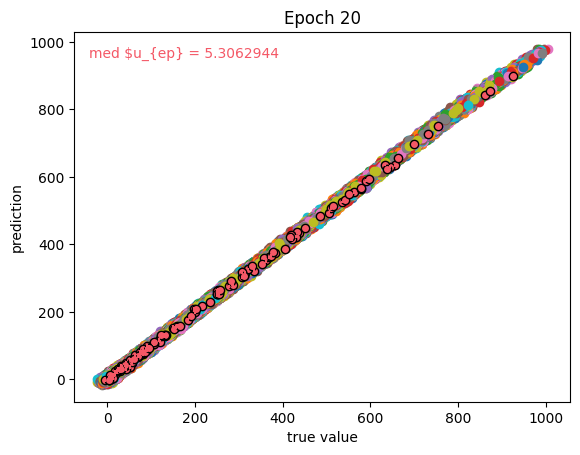

new best loss 3.2478225231170654 in epoch 20
epoch 21 0.21
epoch 22 0.22
epoch 23 0.23
new best loss 3.236963987350464 in epoch 23
epoch 24 0.24
new best loss 3.2269554138183594 in epoch 24
epoch 25 0.25


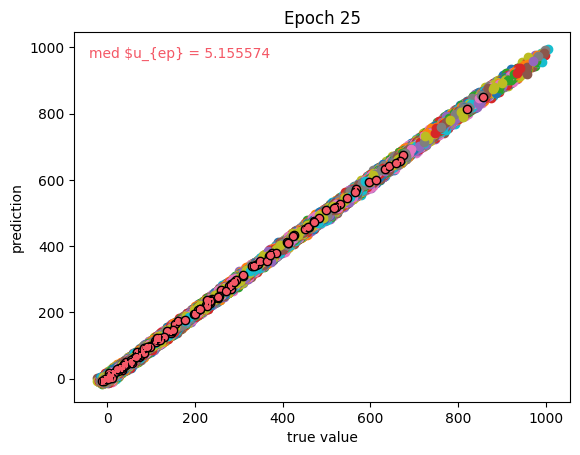

new best loss 3.2151198387145996 in epoch 25
epoch 26 0.26
epoch 27 0.27
epoch 28 0.28
epoch 29 0.29
epoch 30 0.3


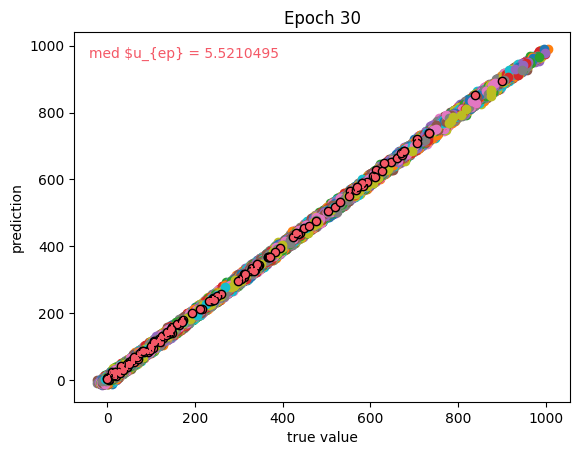

new best loss 3.2059030532836914 in epoch 30
epoch 31 0.31
epoch 32 0.32
epoch 33 0.33
epoch 34 0.34
epoch 35 0.35


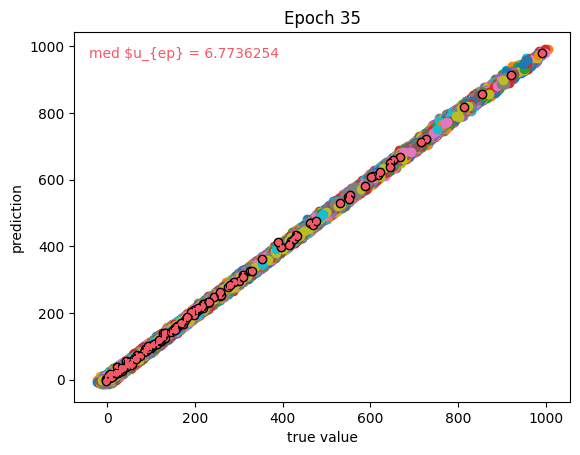

epoch 36 0.36
epoch 37 0.37
epoch 38 0.38
epoch 39 0.39
epoch 40 0.4


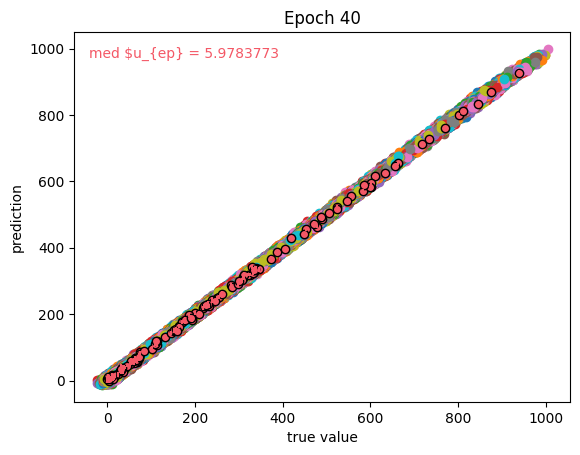

epoch 41 0.41
epoch 42 0.42
new best loss 3.194263458251953 in epoch 42
epoch 43 0.43
epoch 44 0.44
epoch 45 0.45


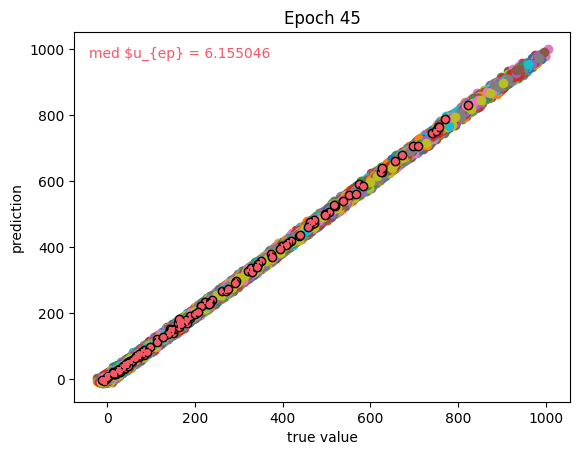

new best loss 3.1841824054718018 in epoch 45
epoch 46 0.46
epoch 47 0.47
new best loss 3.1760029792785645 in epoch 47
epoch 48 0.48
epoch 49 0.49
new best loss 3.173813819885254 in epoch 49
epoch 50 0.5


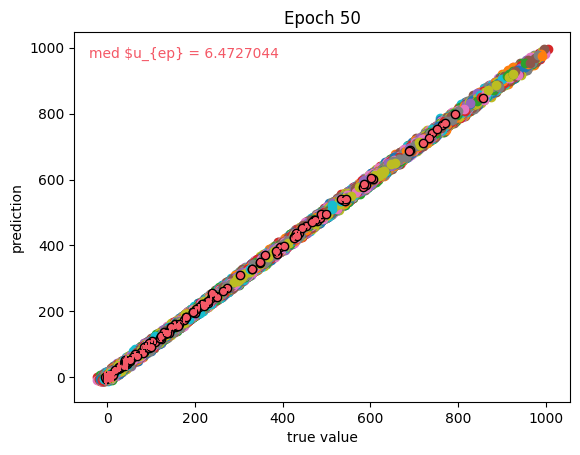

epoch 51 0.51
epoch 52 0.52
epoch 53 0.53
epoch 54 0.54
epoch 55 0.55


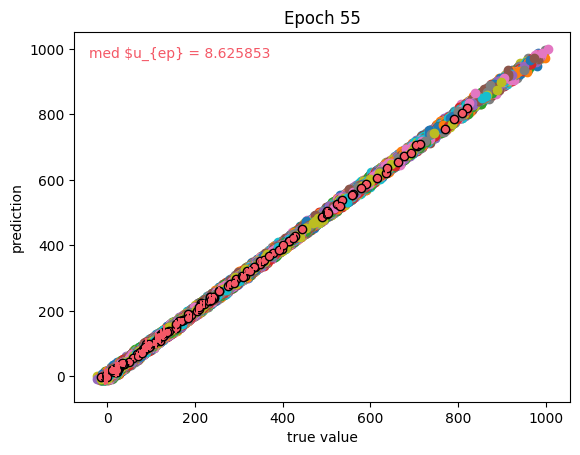

epoch 56 0.56
epoch 57 0.57
epoch 58 0.58
epoch 59 0.59
epoch 60 0.6


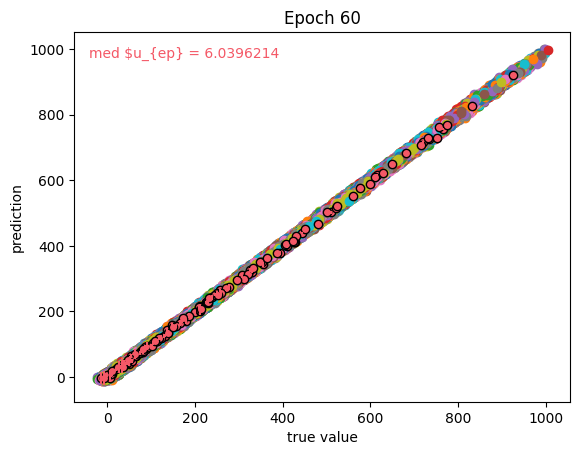

epoch 61 0.61
epoch 62 0.62
epoch 63 0.63
epoch 64 0.64
epoch 65 0.65


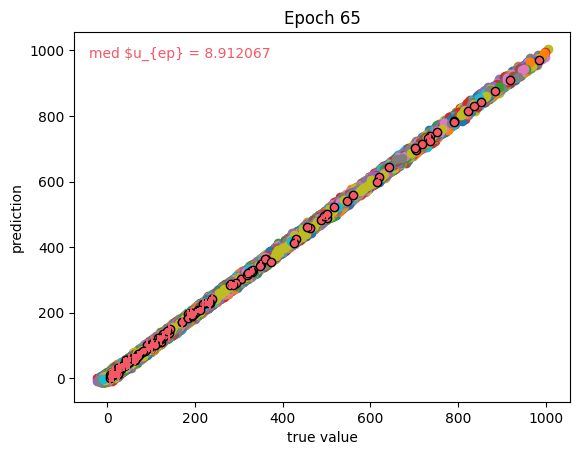

epoch 66 0.66
epoch 67 0.67
epoch 68 0.68
epoch 69 0.69
epoch 70 0.7


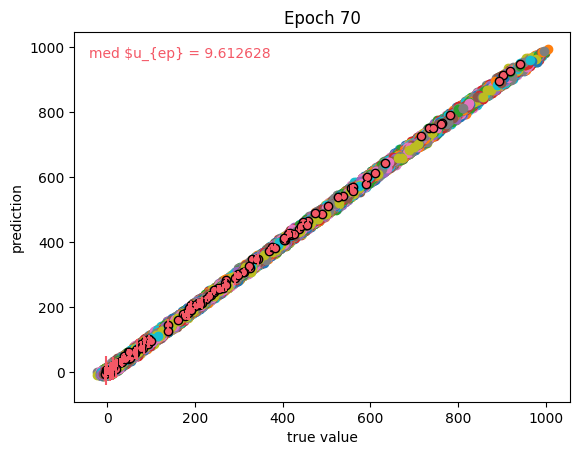

epoch 71 0.71
epoch 72 0.72
epoch 73 0.73
epoch 74 0.74
epoch 75 0.75


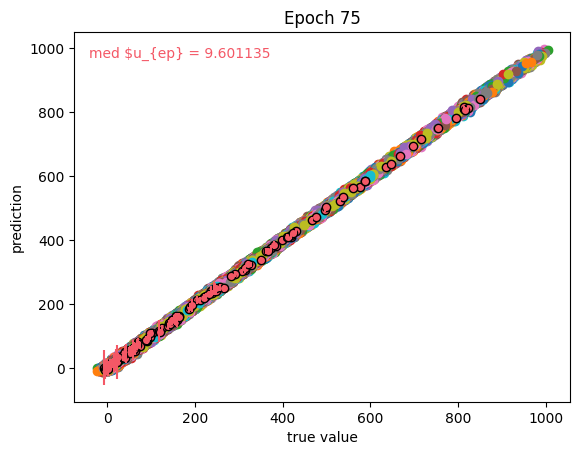

epoch 76 0.76
epoch 77 0.77
epoch 78 0.78
new best loss 3.1629011631011963 in epoch 78
epoch 79 0.79
epoch 80 0.8


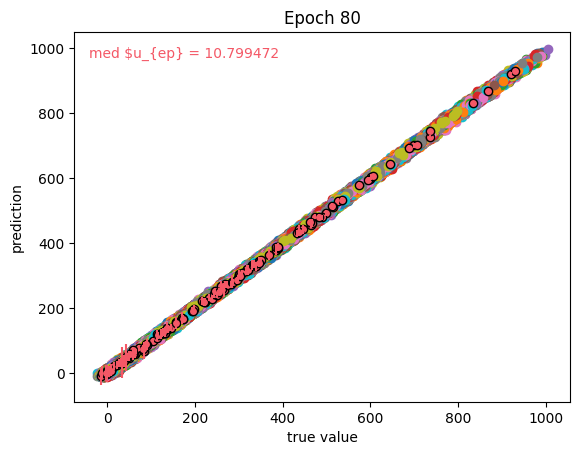

epoch 81 0.81
epoch 82 0.82
epoch 83 0.83
epoch 84 0.84
epoch 85 0.85


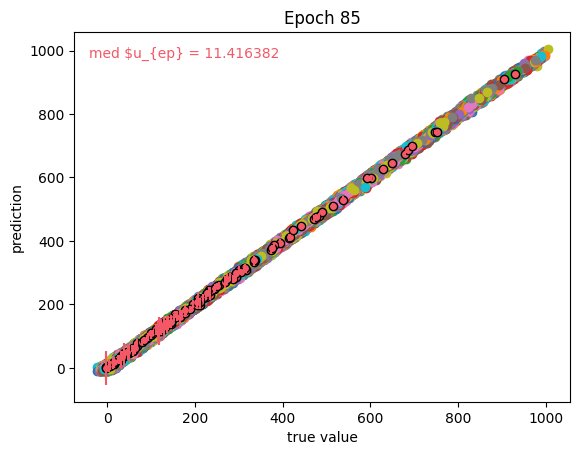

epoch 86 0.86
epoch 87 0.87
epoch 88 0.88
epoch 89 0.89
epoch 90 0.9


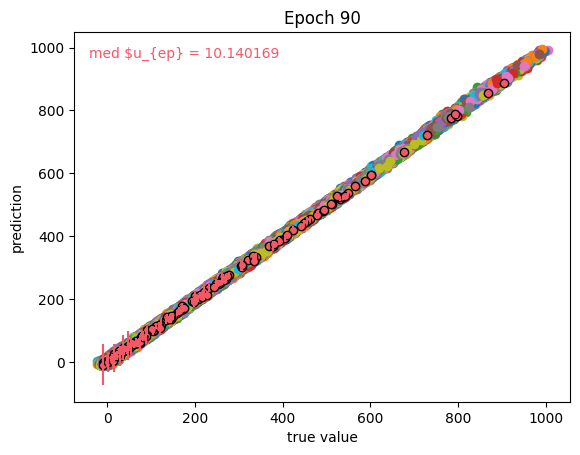

epoch 91 0.91
epoch 92 0.92
epoch 93 0.93
epoch 94 0.94
epoch 95 0.95


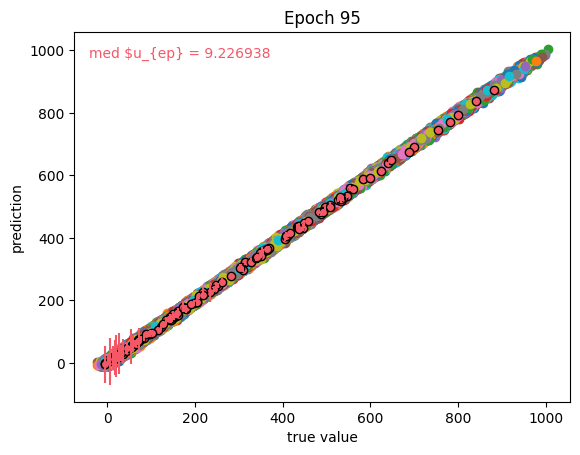

epoch 96 0.96
epoch 97 0.97
epoch 98 0.98
epoch 99 0.99
start at 1708964857.0121028 end at 1708964960.445009
103.43290615081787


<Figure size 640x480 with 0 Axes>

In [60]:
# my own training model
INIT_LR = LR
model_ensemble = train.train_DER(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             COEFF,
             DER_TYPE,
             model_name,
             EPOCHS=n_epochs,
             save_checkpoints=True,
             path_to_model='../models/',
             plot=True)
 

In [ ]:
# run 100 and see how many fail
# my own training model
n_models = 100
mse_list = []
for i in range(n_models):
    INIT_LR = LR
    model_ensemble, final_mse = train.train_DER(trainDataLoader,
                 x_val,
                 y_val,
                 INIT_LR,
                 DEVICE,
                 COEFF,
                 DER_TYPE,
                 model_name,
                 EPOCHS=n_epochs,
                 save_checkpoints=False,
                 path_to_model='../models/',
                 plot=False,
                 verbose=False)
    mse_list.append(final_mse)

In [ ]:
print(range(n_models))
print(mse_list)
plt.clf()
plt.scatter(range(n_models), mse_list)
plt.ylabel('MSE')
plt.xlabel('n_models')
plt.show() 

In [ ]:
# save the mse list
np.save('MSE_DER_100_epochs.npy', mse_list)

### Compute the uncertainty
The original aleatoric and epistemic uncertainty (from OG paper):
$u_{al} = \sqrt{\frac{\beta_i}{(\alpha_i-1)}}$; $u_{ep} = \sqrt{\frac{\beta_i}{v_i(\alpha_i-1)}}$

The revised aleatoric and epistemic uncertainty:
$u_{al} = \sqrt{\frac{\beta_i (1+v_i)}{\alpha_i v_i}}$; $u_{ep} = \frac{1}{\sqrt{v_i}}$

The order of the parameters for a normal-inverse-gamma distribution is:
$$m = (\gamma, \nu, \alpha, \beta)$$

### Plot the aleatoric errors by data point

In [ ]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model = model_ensemble
model.eval()
# first, normalize the x value using the xmin and xmax before
if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
    # I think I'm doing the un-normalization wrong for the other terms in the output:
    aleatoric_OG = np.sqrt((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) - 1))
    aleatoric_mod = np.sqrt(((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) * (1 + (y_norm_pred[:,1] * (outputmax - outputmin) + outputmin))) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) * (y_norm_pred[:,1]* (outputmax - outputmin) + outputmin)))
    epistemic_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,1]*(y_norm_pred[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_norm_pred[:,1])
else:
    y_pred_all_terms = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = y_pred_all_terms[:,0]
    aleatoric_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,2] - 1))
    aleatoric_mod = np.sqrt((y_pred_all_terms[:,3]  * (1 + y_pred_all_terms[:,1] )) / (y_pred_all_terms[:,2] * y_pred_all_terms[:,1]))
    epistemic_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,1]*(y_pred_all_terms[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_pred_all_terms[:,1])

In [ ]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = aleatoric_OG,
             label = r'$u_{al}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax1.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax1.set_title('Aleatoric Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = aleatoric_mod,
             label = r'$u_{al}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax2.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax2.set_title('Aleatoric Error Meinert+2022')
plt.show()

### Now epistemic

In [ ]:
print, epistemic_OG, epistemic_mod 

In [ ]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = epistemic_OG,
             label = r'$u_{ep}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax1.set_title('Epistemic Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = epistemic_mod,
             label = r'$u_{ep}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax2.set_title('Epistemic Error Meinert+2022')
plt.show()
